In [50]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#models
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,auc



# Data processing 

In [51]:
def violin_plot(nrow=4,ncol=2): 
    """
    funtion to plot violin plot for all attributes
    
    input : optional input for number of column and rows for subplot by default value are 2,4 respectively
    
    output : violin plot for all attribute of dataframe 
    
    return : none
    """
    fig = plt.figure(figsize=(14,25))
    fig.tight_layout(pad=3.0)
    nrow,ncol,index=4,2,1    
    for attribute in attributes:
        plt.subplot(nrow, ncol, index)
        plt.title(attribute)
        sns.violinplot(x="Outcome", y=attribute, data=data)
        index+=1
    plt.show()
        
def plot_auc(fpr,tpr,auc_model):
    """This function pots the ROC curve with help of False positive rate
    and True positive rate and auc object
    
    input : false positive rate, ture positive rate,auc of model
    
    output : ROC plot 
    
    return : None
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
 

# calculation of median for each attribute for both possible outcome  
def median_target(attribute):
    """
    This function replaces the Nan of given attribute with 
    median when grouped by Outcome into the global variable 
    data("dataframe")
    
    input : attribute 
    
    output : column of that attibute is modified 
    
    return : none
    """
    temp = data[data[attribute].notnull()]# assigning non null value to temp 
    temp = temp[[attribute, 'Outcome']].groupby(['Outcome'])[[attribute]].mean().reset_index() #calculate mean for a attribute with either 0 or 1 outcome 
    mean_op_0=temp[attribute][0]
    mean_op_1=temp[attribute][1]
    data.loc[(data['Outcome'] == 0 ) & (data[attribute].isnull()), attribute] = mean_op_0 #assigning mean to null values 
    data.loc[(data['Outcome'] == 1 ) & (data[attribute].isnull()), attribute] = mean_op_1

def median_target_all():
    # calling meadian_target for each attribute
    for attribute in attributes:
            median_target(attribute) 
        
def outliers_removal():
    """
    This function removes outlier of the global variable data(dataframe)
    using IQR method 
    """
    #loop for replacing outlier of all attribute with Nan value 
    for attribute in attributes:
        q1 = data[attribute].quantile(0.25)
        q3 = data[attribute].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        data.loc[(data[attribute] < fence_low) | (data[attribute] > fence_high),attribute]=np.nan

        
def z_score(df):
    """Function for apply z score standardization
       Input: dataframe to be standardized
       output :standardized dataframe 
    """
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()     
    return df_std



In [52]:
data = pd.read_csv("diabetes.csv")
attributes = data.drop("Outcome",axis=1).columns

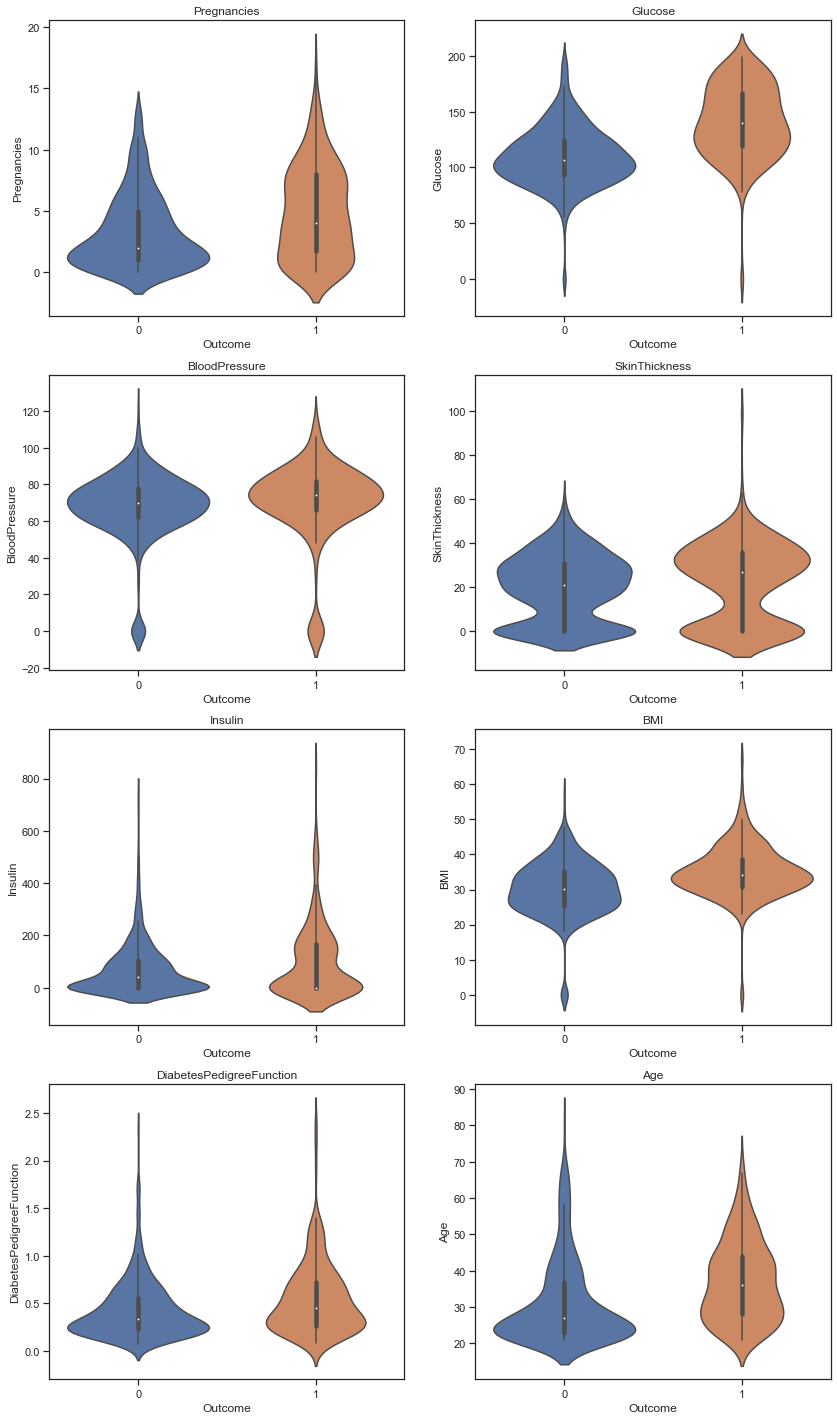

In [ ]:
violin_plot()
sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');


In [ ]:
# replacing missing value with nan value
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)
median_target_all()

outliers_removal()
median_target_all()


In [ ]:
print(data.info())

In [ ]:
fig = plt.figure(figsize=(14,15))
fig.tight_layout(pad=3.0)
nrow,ncol,index=4,2,1    
for attribute in attributes:
    plt.subplot(nrow, ncol, index)
    plt.title(attribute)
    plt.hist(data[attribute][data.Outcome==0],alpha=0.5,label="Outcome=0")
    plt.hist(data[attribute][data.Outcome==1],alpha=0.5,label="Outcome=1")
    plt.legend(loc="best")
    index+=1
plt.show()


In [ ]:

sns.set(style="ticks", color_codes=True)
sns.pairplot(data,hue='Outcome',palette='gnuplot');


In [ ]:
violin_plot()

In [ ]:
# standardization of dataset
data_std=z_score(data)

In [ ]:
# It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data_std.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="YlOrBr")

###### Distribution of data set 

In [ ]:
y = data["Outcome"]
X=data_std.drop("Outcome",axis=1)
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


# Models 

In [ ]:
"""from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
list_of_algo=[SVC(),AdaBoostClassifier(), 
              RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier()]
name_of_algo=["SVM","AdaBoostClassifier", 
              "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier"]
for i,algorithm in enumerate(list_of_algo):
    steps = [('pca', PCA(n_components=6)), ('m', algorithm)]
    model = Pipeline(steps=steps)
# evaluate model
    model_score = cross_val_score(model, X, y, scoring='accuracy', n_jobs=-1, error_score='raise')
    print("*"*120)
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))"""

In [ ]:
list_of_algo=[SVC(probability=True),AdaBoostClassifier(), RandomForestClassifier(),
              LogisticRegression(),KNeighborsClassifier(),XGBClassifier(),GaussianNB()]

name_of_algo=["SVM","AdaBoostClassifier", "RandomForestClassifier",
              "LogisticRegression","KNeighborsClassifier","XGBClassifier","GaussianNB"]

for i,algorithm in enumerate(list_of_algo):
    model=algorithm
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    model_score=cross_val_score(model,X,y,cv=10,scoring="roc_auc")
    
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_model = auc(fpr, tpr)
    print("*"*120)
    print('AUC of {} : {} '.format(name_of_algo[i],(auc_model)))
    print('Accuracy of {} : {} '.format(name_of_algo[i],(model_score.mean()*100)))
    print('Precision of {} : {} '.format(name_of_algo[i],(precision_score(y_test,y_pred)*100)))
    print('Recall of {} : {} '.format(name_of_algo[i],(recall_score(y_test,y_pred)*100)))
    plot_auc(fpr,tpr,auc_model)
    plot_confusion_matrix(model, X_test, y_test,values_format="d")
    plt.title(name_of_algo[i])
    plt.show()    

In [ ]:
"""from sklearn.model_selection import GridSearchCV
print(RandomForestClassifier())
n_estimators = [100, 200, 250, 300, 350]
max_depth = [1, 3, 4, 5, 8, 10]
min_samples_split = [10, 15, 20, 25, 30, 100]
min_samples_leaf = [1, 2, 4, 5, 7] 
max_features = ['auto', 'sqrt']
criterion=['gini']
bootstrap = [True, False]
rfr=RandomForestClassifier()
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,criterion=criterion,
              max_features = max_features,  min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,bootstrap = bootstrap)

gridF = GridSearchCV(rfr, hyperF,scoring='accuracy', cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)"""
"""from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
param_grid = {
    'n_estimators': [100,200,300,],
    'colsample_bytree': [0.5,0.6,0.7],
    'max_depth': [3,5,8],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.8, 0.9,1,1.1],
    'gamma':[1.4,1.5,1.6,]
}
gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring="roc_auc",
        verbose=2
    )
gsf=gs.fit(X_train,y_train)
print(gsf.best_params_)"""

In [ ]:
#print(gsf.best_params_)
#forestOpt = RandomForestClassifier(n_estimators = 100,criterion='gini',bootstrap= False,max_depth= 3,max_features='auto'
 #                                 ,min_samples_leaf= 4)
forestOpt = RandomForestClassifier(n_estimators = 100,criterion='gini',bootstrap= False,max_depth= 3,max_features='auto'
                                  ,min_samples_leaf= 4,random_state=6)
modelfit = XGBClassifier(colsample_bytree = 0.5,max_depth = 8,n_estimators=100,reg_alpha=1.1,reg_lambda=1.1, subsample=1,gamma=1.5)
modelfit.fit(X_train,y_train)
modelOpt = forestOpt.fit(X_train, y_train)
model_score=cross_val_score(modelfit,X,y,cv=10,scoring="roc_auc")
y_pred = modelOpt.predict(X_test)
print(modelfit.score(X_test,y_test))
print("score",model_score.mean())
print(*model_score)

In [ ]:

##Build an model(Neural model )
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fit=model.fit(X_train, y_train, epochs=200, batch_size=8)
_, nn_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_nn = auc(fpr, tpr)
plot_auc(fpr,tpr,auc_nn)



In [ ]:
import pickle
# Save trained model to file
pickle.dump(modelfit, open("Diabetes.pkl", "wb"))
loaded_model = pickle.load(open("Diabetes.pkl", "rb"))
loaded_model.predict(X_test)
loaded_model.score(X_test,y_test)